# Ghana Health Facilities 

In [59]:
# Data libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import plotly.graph_objects as go 
import math as mt
# libraries for download the data 
import os 
from urllib.request import urlretrieve

In [2]:
URL = 'https://data.gov.gh/sites/default/files/harvest_resources/HEALTH%2520FACILITIES%2520IN%2520GHANA.csv'

In [3]:
#urlretrieve(URL, 'FacilitiesHealth.csv')

In [4]:
def download_data(url = URL, filename = 'FacilitiesHealth.csv', force = False):
    if not os.path.exists(filename):
        urlretrieve(url, filename)
        
    if force == True:
        urlretrieve(url, filename)
        
    data = pd.read_csv('FacilitiesHealth.csv')
    return data 
        
        

In [5]:
data_facilities = download_data(force = True)
print(data_facilities.shape)
data_facilities.head()


(3756, 8)


,Region,District,FacilityName,Type,Town,Ownership,Latitude,Longitude
0,Ashanti,Offinso North,A.M.E Zion Clinic,Clinic,Afrancho,CHAG,7.40801,-1.96317
1,Ashanti,Bekwai Municipal,Abenkyiman Clinic,Clinic,Anwiankwanta,Private,6.46312,-1.58592
2,Ashanti,Adansi North,Aboabo Health Centre,Health Centre,Aboabo No 2,Government,6.22393,-1.34982
3,Ashanti,Afigya-Kwabre,Aboabogya Health Centre,Health Centre,Aboabogya,Government,6.84177,-1.61098
4,Ashanti,Kwabre,Aboaso Health Centre,Health Centre,Aboaso,Government,6.84177,-1.61098


In [19]:
#looking for null data 
for col in data_facilities.columns:
    print(col, data_facilities.loc[:,col].isnull().sum())

Region 0
District 0
FacilityName 0
Type 0
Town 153
Ownership 0
Latitude 24
Longitude 24


In the dataset exist a few null data but still can be used so won't be erased rigth now

In [20]:
# This are the all the rows with miss data 
rows_nullData = data_facilities.loc[data_facilities.loc[:,'Town'].isnull() | data_facilities.loc[:,'Latitude'].isnull() | data_facilities.loc[:,'Longitude'].isnull() | data_facilities.loc[:,'Type'].isnull() | data_facilities.loc[:,'Ownership'].isnull()]
rows_nullData.head()

,Region,District,FacilityName,Type,Town,Ownership,Latitude,Longitude
357,Ashanti,Bosome Freho,Dunkura Health Centre,health centre,Dunkura,government,NaN,NaN
358,Ashanti,Bosome Freho,Yapesa St.Mary Clinic,clinic,Yapesa,chag,NaN,NaN
596,Ashanti,Kumasi Metropolitan,Amansie Enterprise Clinic,clinic,NaN,private,6.41500,-1.37548
626,Ashanti,Kumasi Metropolitan,Restoration Clinic,clinic,NaN,private,6.41500,-1.37548
645,Ashanti,Mampong Municipal,Calvary Health Service,clinic,NaN,private,7.03397,-1.24294


In [21]:
for col in ['Region', 'Type', 'Ownership']:
    print(col,  '\n', data_facilities.loc[:,col].value_counts(), '\n')

Region 
 Ashanti          658
Greater Accra    504
Western          496
Volta            398
Eastern          393
Brong Ahafo      348
Central          299
Northern         267
Upper East       232
Upper West       161
Name: Region, dtype: int64 

Type 
 clinic                         1173
health centre                   786
chps                            652
maternity home                  369
hospital                        277
rch                             152
district health directorate      99
others                           92
district hospital                82
training institution             74
Name: Type, dtype: int64 

Ownership 
 government          2216
private             1181
chag                 257
quasi-government      91
others                11
Name: Ownership, dtype: int64 



Exist a lot of values that only appears a few times in types and ownership, furthermore exist values that were wrote more than once but without capital letters. To correct this, firstits necesary correct the values and then merge all values that have less than 50 to facilitate the analisis BUT this is only for a rough analysis of the general health facilities in the region not a specified analysis of wich types of facilities are needed according to the population needs, to do it will be necesary information about average situation of the patients and doctors.

In [159]:
# to correct the repeated values 
data_facilities.loc[:,'Type'] = data_facilities.loc[:,'Type'].str.lower()
data_facilities.loc[:,'Ownership'] = data_facilities.loc[:,'Ownership'].str.lower()
# In the previous code one of the rows with null data havent the most of the info so is discarted
data_facilities = data_facilities.drop(data_facilities.loc[data_facilities.loc[:,'Type'].isnull()].index)


#error: exist the same facilities writed more than once 
print(data_facilities.shape)
data_gh_clean = data_facilities.drop_duplicates(subset = ['Latitude', 'Longitude'], keep = 'first')
print(data_gh_clean.shape)
#error:  are two facilities excesiveley far from the others in the 'same' region
#Abu Clinic and Asemnyinakrom Health Centre

data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Abu Clinic'].index, 'Region'] = 'Northern'

data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Asemnyinakrom Health Centre'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'New Papaase CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Nsowakrom CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Owusu Ansah CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Fosukrom CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Arhinful CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Amoashed CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Kwametawiahkrom CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Cashier CPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Eye Ewurade Maternity Home'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Kwasi Nkrumah CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'St. John of God Clinic Annex'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'St. Luke Methodist Clinic'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Presby Clinic'].index, 'Region'] = 'Ashanti'



data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Infirmary Clinic'].index, 'Region'] = 'Upper West'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Scho ol for the Deaf Clinic'].index, 'Region'] = 'Upper West'





(3756, 8)
(2881, 8)


In [161]:
# Assign all the values under 50 to "others"
temp = data_facilities.loc[:,'Type'].value_counts()
for idx in data_facilities.loc[:,'Type'].unique():
    if temp[idx] < 50:
        data_facilities.loc[(data_facilities.loc[:,'Type'] == idx), 'Type'] = 'others'
        
        
for idx in data_facilities.loc[:,'Ownership'].unique():
    temp = data_facilities.loc[:,'Ownership'].value_counts()
    if temp[idx] < 50:
        data_facilities.loc[(data_facilities.loc[:,'Ownership'] == idx), 'Ownership'] = 'others'
    
    

## Exploring the Data

In [162]:
data_facilities_region = data_facilities.groupby(['Region','Type'])['Type'].count()
data_facilities_region = data_facilities_region.reset_index(name = 'Sum_Type')
data_facilities_region.head()

,Region,Type,Sum_Type
0,Ashanti,chps,22
1,Ashanti,clinic,271
2,Ashanti,district health directorate,2
3,Ashanti,district hospital,14
4,Ashanti,health centre,137


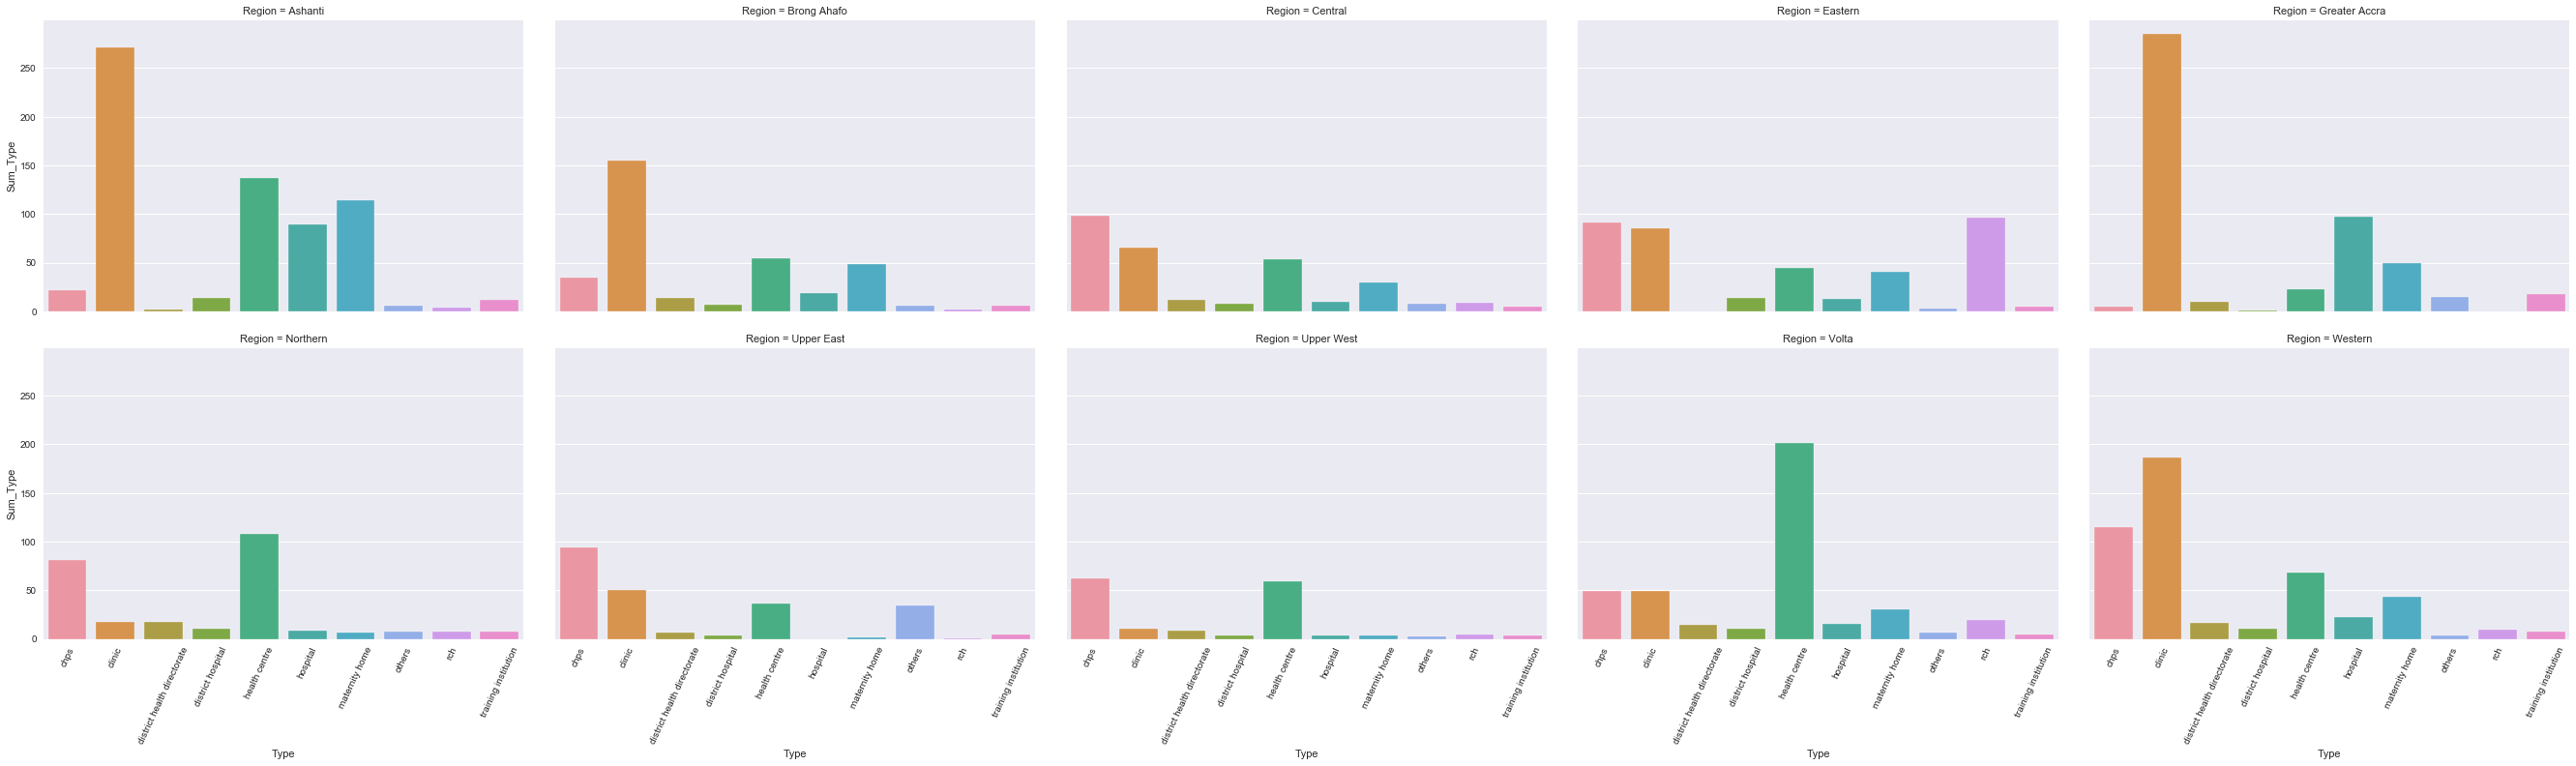

In [163]:
# Plot the number and type of facilities per region 
plt.style.use('seaborn')
region = sns.catplot( x = 'Type', y = 'Sum_Type', col = 'Region', data = data_facilities_region, kind = 'bar', height = 5, aspect = 1.5, col_wrap = 5, legend = True)
region.set_xticklabels(rotation = 65)

for axe in region.axes.flat:
    axe.set_xticklabels(axe.get_xticklabels(), rotation = 65)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text xticklabel objects>)

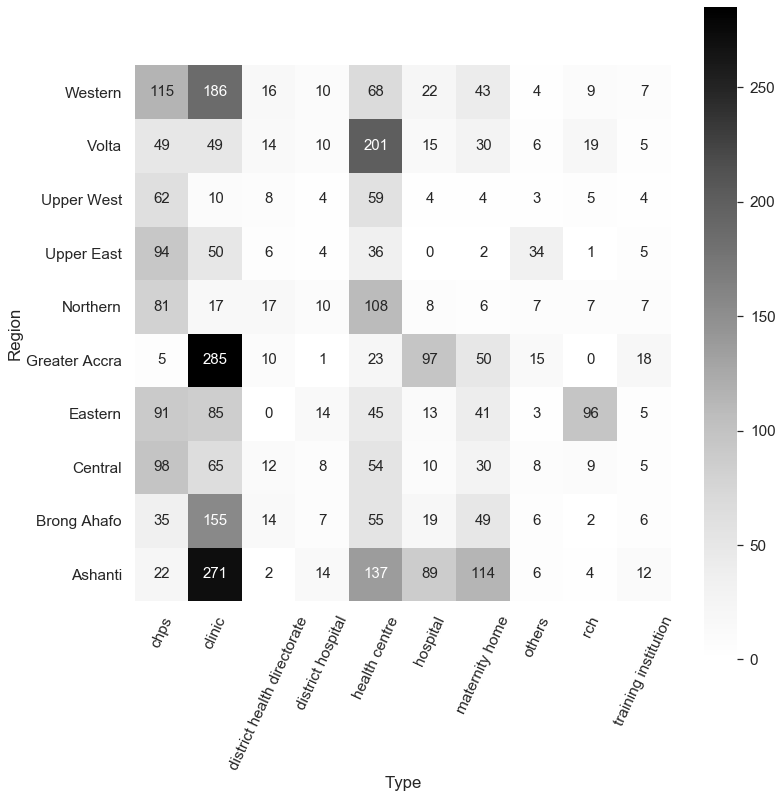

In [164]:
pivot_data_Facilities = pd.pivot_table(data_facilities_region, values = 'Sum_Type', index = ['Region'], columns = ['Type'])
#Exist some empty values, This will asume that if doesnt 
pivot_data_Facilities = pivot_data_Facilities.fillna(0)

plt.figure(figsize = (12,12))
sns.set(font_scale=1.4)
heat = sns.heatmap(pivot_data_Facilities, square = True, annot = True, annot_kws = {'size': 15},fmt ='g', cmap = 'Greys')

heat.set_ylim([0,10])
plt.yticks(rotation = 0)
plt.xticks(rotation = 65)

In [165]:
# table with resume 
max_region = []
for region in data_facilities_region.loc[:,'Region'].unique():
    idx = data_facilities_region.loc[data_facilities_region['Region'] == region].Sum_Type.idxmax()
    max_region.append ([region, data_facilities_region.loc[idx,'Type'], data_facilities_region.loc[idx,'Sum_Type']])

df_max_region = pd.DataFrame(max_region, columns = ['Region', 'Type', 'Sum_Type'])
df_max_region

,Region,Type,Sum_Type
0,Ashanti,clinic,271
1,Brong Ahafo,clinic,155
2,Central,chps,98
3,Eastern,rch,96
4,Greater Accra,clinic,285
5,Northern,health centre,108
6,Upper East,chps,94
7,Upper West,chps,62
8,Volta,health centre,201
9,Western,clinic,186


In [166]:
def percentage_type(col_group, col_obj, data):
    data_group_type = data.groupby([col_group])[col_obj].count()
    data_group_type = data_group_type.apply(lambda x: (x/data_group_type.sum())*100)
    return data_group_type

In [167]:

data_ownership = percentage_type('Ownership', 'Type', data_facilities)
data_type = percentage_type('Type', 'Type', data_facilities)


Text(0.5, 1.0, 'Percentage of facilities by Types')

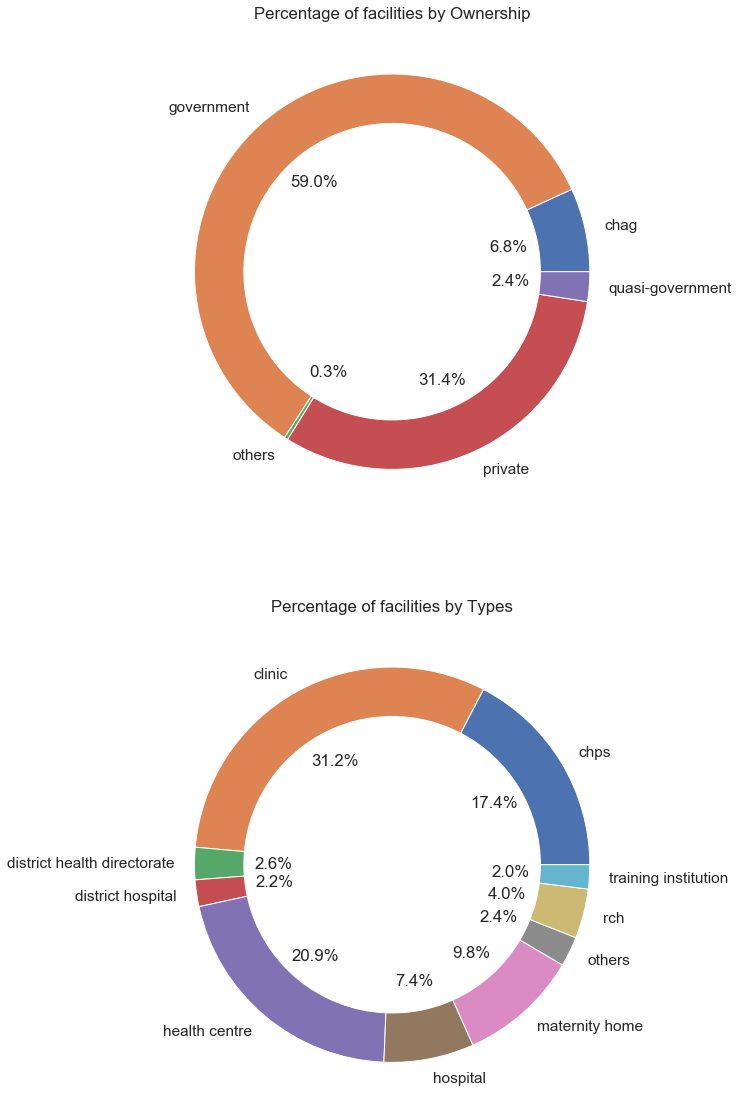

In [168]:
fig, ax = plt.subplots(2,1, figsize = (20,20))
ax[0].pie(data_ownership, labels = data_ownership.index, autopct = '%1.1f%%', wedgeprops=dict(width=0.25))
ax[0].set_title('Percentage of facilities by Ownership')
ax[1].pie(data_type, labels = data_type.index, autopct = '%1.1f%%', wedgeprops=dict(width=0.25))
ax[1].set_title('Percentage of facilities by Types')

In [169]:
#max locations to center the map plot 
max_latitude = data_facilities.Latitude.max()
min_latitude =  data_facilities.Latitude.min()
max_longitude = data_facilities.Longitude.max()
min_longitude =  data_facilities.Longitude.min()

#if the color is not defined in dataset its easier to complete all the information requirements using 
#for loop 
map_facilities = []
for index, region in enumerate(data_facilities.Region.unique()):
    map_facilities.append(
    go.Scattergeo(
                  lon = data_facilities.loc[data_facilities.Region == region].Longitude,
                  lat = data_facilities.loc[data_facilities.Region == region].Latitude,
                  text = data_facilities.loc[data_facilities.Region == region].FacilityName,
                  mode = 'markers',
                  marker_color = index,#data_gh_clean.loc[data_gh_clean.Region == region].index,
                  name = region
                  ))

layout = dict(
              title = 'Facilities in Ghana per Region',
              geo = dict(
              scope = 'africa',
              showland = True,
              lonaxis = dict(
                             showgrid = True,
                             gridwidth = 0.5,
                             range = [min_longitude - 1, max_longitude + 1],
                             dtick = 5),
              lataxis = dict(
                             showgrid = True,
                             gridwidth = 0.5,
                             range = [min_latitude - 1, max_latitude + 1],
                             dtick = 5),
              landcolor = 'rgb(250, 250, 250)',
              subunitcolor = 'rgb(217, 217, 217)',
              countrycolor = 'rgb(217, 217, 217)',
              countrywidth = 0.5,
              subunitwidth = 0.5),)

figure = dict( data = map_facilities, layout = layout)
go.Figure(figure).show()

In [174]:
#calculate the distance between two points with cardinal coordinates
def distance (lat1, log1, lat2, log2):
    radius = 6371 #radius of earth in km
    lat1_rad = mt.radians(lat1)
    lat2_rad = mt.radians(lat2)
    delta_lat = mt.radians(lat1-lat2)
    delta_log = mt.radians(log1-log2)
    
    a = mt.sin(delta_lat/2)**2 + (mt.cos(lat1_rad) * mt.cos(lat2_rad) * mt.sin(delta_log/2)**2)
    c = 2 * mt.atan2( mt.sqrt(a), mt.sqrt(1 - a))
    dist = radius * c
    
    return dist

In [ ]:
def facilities_range()

In [175]:
#Calculate the distances between Clinics - Health Center and Hospitals - Clinics 
#assuming this hierarchy by the order of capacities of the facilities
predominate_facilities = data_facilities.loc[(data_facilities.Type == 'clinic') | (data_facilities.Type == 'hospital') | (data_facilities.Type == 'health centre')]
dist_Clinics = []
dist_Hospitals = []

In [176]:
%%time
for id1 in predominate_facilities.index:
    if predominate_facilities.loc[id1, 'Type'] == 'clinic':
        for id2 in predominate_facilities.index:
            if predominate_facilities.loc[id1, 'Region'] == predominate_facilities.loc[id2, 'Region'] and predominate_facilities.loc[id2, 'Type'] == 'health centre':
                lat1  = predominate_facilities.loc[id1, 'Latitude']
                long1 = predominate_facilities.loc[id1, 'Longitude']
                lat2  = predominate_facilities.loc[id2, 'Latitude']
                long2 = predominate_facilities.loc[id2, 'Longitude']
                dist_facilities = distance(lat1, long1, lat2, long2)
                name_clinic = predominate_facilities.loc[id1, 'FacilityName']
                name_health = predominate_facilities.loc[id2, 'FacilityName']
                dist_Clinics.append([predominate_facilities.loc[id1, 'Region'], name_clinic, name_health, dist_facilities])
    
    if predominate_facilities.loc[id1, 'Type'] == 'hospital':
        for id2 in predominate_facilities.index:
            if predominate_facilities.loc[id1, 'Region'] == predominate_facilities.loc[id2, 'Region'] and predominate_facilities.loc[id2, 'Type'] == 'clinic':
                lat1  = predominate_facilities.loc[id1, 'Latitude']
                long1 = predominate_facilities.loc[id1, 'Longitude']
                lat2  = predominate_facilities.loc[id2, 'Latitude']
                long2 = predominate_facilities.loc[id2, 'Longitude']
                dist_facilities = distance(lat1, long1, lat2, long2)
                name_hospital = predominate_facilities.loc[id1, 'FacilityName']
                name_clinic = predominate_facilities.loc[id2, 'FacilityName']
                dist_Hospitals.append([predominate_facilities.loc[id1, 'Region'], name_hospital, name_clinic, dist_facilities])

Wall time: 1min 36s


In [177]:
distance_Clinics_Health = pd.DataFrame(dist_Clinics, columns = ['Region', 'FirstFacilityName', 'SecondFacilityName', 'Distance'])
distance_Hospitals_Clinics = pd.DataFrame(dist_Hospitals, columns = ['Region', 'FirstFacilityName', 'SecondFacilityName', 'Distance'])
distance_Clinics_Health.head()

,Region,FirstFacilityName,SecondFacilityName,Distance
0,Ashanti,A.M.E Zion Clinic,Aboabo Health Centre,148.057665
1,Ashanti,A.M.E Zion Clinic,Aboabogya Health Centre,73.989031
2,Ashanti,A.M.E Zion Clinic,Aboaso Health Centre,73.989031
3,Ashanti,A.M.E Zion Clinic,Aboffour Health Centre,40.018526
4,Ashanti,A.M.E Zion Clinic,Achiase Health Centre,128.128407


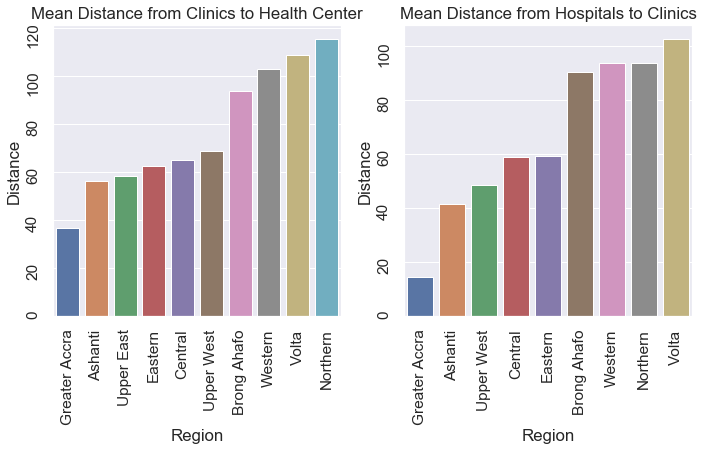

In [178]:

mean_distances_Clinics = distance_Clinics_Health.groupby(['Region']).Distance.mean().sort_values()
mean_distances_Hospitals = distance_Hospitals_Clinics.groupby(['Region']).Distance.mean().sort_values()



fig, ax = plt.subplots(1,2, figsize = (10,5))
fig.tight_layout()
sns.barplot(x = mean_distances_Clinics.index, y = mean_distances_Clinics, ax = ax[0,])
ax[0].set_title('Mean Distance from Clinics to Health Center')
ax[0].tick_params(labelrotation=90)

sns.barplot(x = mean_distances_Hospitals.index, y = mean_distances_Hospitals, ax = ax[1])
ax[1].set_title('Mean Distance from Hospitals to Clinics')
ax[1].tick_params(labelrotation=90)

